## Machine Learning & AI

![Colegio Bourbaki](./Images/Bourbaki.png)

### Deep Reinforcement Learning

Este proyecto aprovecha un modelo de aprendizaje profundo de IA para optimizar y reducir el consumo energético de un centro de datos hasta en un 70%. El modelo de IA utiliza el algoritmo Q-Learning para determinar la mejor acción en cada paso temporal. Q-Learning se basa en las ecuaciones de Bellman, que son la base del aprendizaje por refuerzo.

El proyecto pretende reducir el consumo energético de una instalación industrial. Se utiliza un modelo de optimización de aprendizaje profundo y se compara con el sistema de refrigeración integrado tradicional. El enfoque se inspira en la reducción del 40% lograda en los centros de datos de Google utilizando el modelo de IA de DeepMind. El proyecto forma parte del módulo Artificial Intelligence for Business de Udemy.

**En este escenario, hay dos supuestos clave:**

* La temperatura intrínseca de un servidor es una función de la temperatura atmosférica, el número de usuarios en el servidor y la velocidad de transmisión de datos. La relación se aproxima mediante una combinación lineal de esas 3 variables. Los coeficientes se estiman mediante un análisis de regresión.

* La energía gastada para regular la temperatura entre dos pasos temporales es proporcional al cambio absoluto de temperatura. Utilizando esta relación lineal, podemos estimar que el consumo de energía de cada mecanismo es proporcional al cambio absoluto de temperatura del servidor. Esto se aplica tanto al sistema de IA como al sistema de refrigeración integrado tradicional.

Q-Learning es un algoritmo de aprendizaje por refuerzo para aprender la calidad de las acciones que indica a un agente qué acción debe realizar en qué circunstancias. Determina el valor de todas las acciones posibles dado un determinado estado (o circunstancias). No requiere un modelo del entorno, ya que lo aprende mientras lo explora. Los valores de las acciones (o Calidad de las acciones) se determinan recursivamente a medida que el algoritmo explora el entorno y aprende de los resultados obtenidos a lo largo de un elevado número de iteraciones. El aprendizaje Q encuentra una política óptima (secuencia de acciones) que maximiza el valor esperado de la recompensa total en todos y cada uno de los pasos sucesivos, partiendo del estado actual. En otras palabras, el aprendizaje Q puede identificar una política óptima de selección de acciones para cualquier proceso de decisión de Markov finito (no depende del pasado, sino únicamente de las acciones futuras), dado un tiempo de exploración infinito y una política parcialmente aleatoria.

Así, la ecuación de Bellman descompone el valor en dos partes, la recompensa inmediata más los valores futuros descontados. La ecuación de Bellman aparece por todas partes en la literatura del Aprendizaje por Refuerzo, siendo uno de los elementos centrales de muchos algoritmos de Aprendizaje por Refuerzo.

En este proyecto, la recompensa se define como la diferencia absoluta entre la energía requerida por el sistema de refrigeración y la energía requerida por el modelo de IA. Esta es la energía ahorrada por la IA.

El proyecto utiliza una red neuronal sencilla formada por 3 capas totalmente conectadas. La red toma como entrada un vector normalizado que representa el estado. En este problema, el estado está representado por la temperatura del servidor, el número de usuarios y la velocidad de transmisión de datos. El estado se actualiza en cada paso temporal.

Las dos capas ocultas tienen 64 y 32 nodos respectivamente.

La capa de salida predice los valores Q para 5 acciones potenciales que cubren las opciones disponibles para el sistema. Una función de activación softmax genera una distribución de probabilidad sobre las acciones. La probabilidad más alta corresponde al valor Q más alto.

La fase de aprendizaje utiliza la técnica "Experience Replay" para entrenar.

### Librerías

In [1]:
#DQN
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#Utils
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

### Ambiente

El siguiente código define un entorno simulado para un escenario de aprendizaje por refuerzo (RL) en el que el objetivo es gestionar la temperatura de una sala de servidores de forma eficiente mediante el uso de inteligencia artificial (IA). Simula la dinámica del entorno, incluidos los cambios de temperatura debidos a las condiciones atmosféricas, el número de usuarios y la velocidad de procesamiento de datos, que en conjunto influyen en la temperatura de la sala de servidores. El agente de IA interactúa con este entorno realizando acciones para ajustar el sistema de refrigeración del servidor, con el objetivo de mantener la temperatura dentro de un rango óptimo. La eficacia de estas acciones se evalúa mediante un sistema de recompensas que penaliza el uso excesivo de energía y recompensa la gestión eficiente de la temperatura.

La clase Environment encapsula todos los parámetros, variables y métodos necesarios para simular el escenario de gestión de la temperatura de la sala de servidores. Desglosemos los métodos:

**__init__:**

Inicializa el entorno con los siguientes parámetros:

* optimal_temperature: El rango de temperatura objetivo para la sala de servidores.
* initial_month: El mes inicial, que afecta a la temperatura ambiente.
* initial_number_users: El número inicial de usuarios que utilizan los recursos del servidor.
* initial_rate_data: La tasa inicial de datos que procesa el servidor.

Estos parámetros influyen en el estado inicial del entorno, incluyendo la temperatura atmosférica, la temperatura intrínseca de la sala del servidor (basada en los usuarios actuales y la tasa de datos), y la temperatura inicial establecida por los sistemas AI y no AI.

**update_env:**

Simula el efecto de una acción realizada por la IA para ajustar la temperatura. Actualiza el estado del entorno en función de la dirección y la magnitud de la acción, el cambio en el número de usuarios y la velocidad de procesamiento de datos. También calcula la nueva recompensa basándose en la energía utilizada por la IA y el sistema no IA, actualiza la temperatura de la sala del servidor y comprueba si el juego ha terminado debido a que la temperatura ha caído fuera del rango permitido.

**reset:**

Reinicia el entorno a un mes especificado, reinicializando la temperatura atmosférica y otras variables de estado a sus valores iniciales. Este método se utiliza para iniciar un nuevo episodio en el contexto RL.

**observe:**

Proporciona el estado actual del entorno al agente de la IA. Esto incluye las versiones escaladas de la temperatura del servidor, el número de usuarios y la tasa de procesamiento de datos, junto con la última recompensa recibida y si el proceso ha terminado.

In [ ]:
# ==== 1. ENVIRONMENT FOR CONTINUOUS ACTION SPACE ====

class Environment:
    def __init__(
        self,
        optimal_temperature=(18.0, 24.0),
        initial_month=0,
        initial_number_users=10,
        initial_rate_data=60,
    ):
        self.initial_month = initial_month
        self.monthly_atmospheric_temperatures = [1.0, 5.0, 7.0, 10.0, 11.0, 20.0, 23.0, 24.0, 22.0, 10.0, 5.0, 1.0]
        self.atmospheric_temperature = self.monthly_atmospheric_temperatures[initial_month]
        self.optimal_temperature = optimal_temperature
        self.min_temperature = -20
        self.max_temperature = 80
        self.min_number_users = 10
        self.max_number_users = 100
        self.max_update_users = 5
        self.initial_number_users = initial_number_users
        self.current_number_users = initial_number_users
        self.min_rate_data = 20
        self.max_rate_data = 300
        self.max_update_data = 10
        self.initial_rate_data = initial_rate_data
        self.current_rate_data = initial_rate_data
        self.intrinsic_temperature = self.atmospheric_temperature + 1.25 * self.current_number_users \
                                    + 1.25 * self.current_rate_data
        self.temperature_ai = self.intrinsic_temperature
        self.temperature_noai = (self.optimal_temperature[0] + self.optimal_temperature[1]) / 2.0 # mid of optimal range
        self.total_energy_ai = 0.0
        self.total_energy_noai = 0.0    
        self.reward = 0.0
        self.game_over = 0
        self.reset(new_month=initial_month)
        self.train = 1

    def update_env(self, action, month):
        self.previous_action = action
        delta_temperature_ai = action
        energy_ai = abs(delta_temperature_ai)
   

        # Compute energy for no-AI (baseline)
        energy_noai = 0
        if self.temperature_noai < self.optimal_temperature[0]:
            energy_noai = self.optimal_temperature[0] - self.temperature_noai
            self.temperature_noai = self.optimal_temperature[0]
        elif self.temperature_noai > self.optimal_temperature[1]:
            energy_noai = self.temperature_noai - self.optimal_temperature[1]
            self.temperature_noai = self.optimal_temperature[1]

        # Base reward: encourage energy savings
        self.reward = (energy_noai - energy_ai) * 1e-1  # reduced to prioritize penalty
        # penalty = 0.0
        # penalty_coeff = 1e-2  # Coefficient for the penalty term
        # if self.temperature_ai < self.optimal_temperature[0]:
        #     deviation = self.optimal_temperature[0] - self.temperature_ai
        #     penalty = - (deviation ** 2) * penalty_coeff
        # elif self.temperature_ai > self.optimal_temperature[1]:
        #     deviation = self.temperature_ai - self.optimal_temperature[1]
        #     penalty = - (deviation ** 2) * penalty_coeff

        # self.reward = 1e-1 * (energy_noai - energy_ai) + penalty

        # Update atmospheric conditions and intrinsic temperature
        self.atmospheric_temperature = self.monthly_atmospheric_temperatures[month]
        self.current_number_users += np.random.randint(-self.max_update_users, self.max_update_users + 1)
        self.current_number_users = np.clip(self.current_number_users, self.min_number_users, self.max_number_users)
        self.current_rate_data += np.random.randint(-self.max_update_data, self.max_update_data + 1)
        self.current_rate_data = np.clip(self.current_rate_data, self.min_rate_data, self.max_rate_data)

        past_intrinsic_temperature = self.intrinsic_temperature
        self.intrinsic_temperature = (
            self.atmospheric_temperature +
            1.25 * self.current_number_users +
            1.25 * self.current_rate_data
        )
        delta_intrinsic = self.intrinsic_temperature - past_intrinsic_temperature

        self.temperature_ai += delta_intrinsic + delta_temperature_ai
        self.temperature_noai += delta_intrinsic

        # Check for overflow (only in training)
        if self.temperature_ai < self.min_temperature:
            if self.train:
                self.game_over = True
            else:
                self.total_energy_ai += self.optimal_temperature[0] - self.temperature_ai
                self.temperature_ai = self.optimal_temperature[0]
        elif self.temperature_ai > self.max_temperature:
            if self.train:
                self.game_over = True
            else:
                self.total_energy_ai += self.temperature_ai - self.optimal_temperature[1]
                self.temperature_ai = self.optimal_temperature[1]

        # Track total energy
        self.total_energy_ai += energy_ai
        self.total_energy_noai += energy_noai

        # Normalize state
        # next_state = np.array([
        #     (self.temperature_ai - self.min_temperature) / (self.max_temperature - self.min_temperature),
        #     (self.current_number_users - self.min_number_users) / (self.max_number_users - self.min_number_users),
        #     (self.current_rate_data - self.min_rate_data) / (self.max_rate_data - self.min_rate_data),
        # ])

        # # Optional: Clip temperature_ai for stability (only during evaluation)
        if not self.train:
            self.temperature_ai = np.clip(self.temperature_ai, self.min_temperature, self.max_temperature)


        next_state = np.array([
            (self.temperature_ai - self.min_temperature) / (self.max_temperature - self.min_temperature),
            (self.temperature_noai - self.min_temperature) / (self.max_temperature - self.min_temperature),
            (self.current_number_users - self.min_number_users) / (self.max_number_users - self.min_number_users),
            (self.current_rate_data - self.min_rate_data) / (self.max_rate_data - self.min_rate_data),
            (self.atmospheric_temperature - min(self.monthly_atmospheric_temperatures)) /
                (max(self.monthly_atmospheric_temperatures) - min(self.monthly_atmospheric_temperatures)),
            (self.intrinsic_temperature - self.min_temperature) / (self.max_temperature - self.min_temperature)
        ]) 

        return next_state, self.reward, self.game_over

    def reset(self, new_month):
        self.atmospheric_temperature = self.monthly_atmospheric_temperatures[new_month]
        self.initial_month = new_month
        self.current_number_users = self.initial_number_users
        self.current_rate_data = self.initial_rate_data
        self.intrinsic_temperature = self.atmospheric_temperature + 1.25 * self.current_number_users \
                                     + 1.25 * self.current_rate_data
        self.temperature_ai = self.intrinsic_temperature
        self.temperature_noai = (self.optimal_temperature[0] + self.optimal_temperature[1]) / 2.0
        self.total_energy_ai = 0.0
        self.total_energy_noai = 0.0
        self.reward = 0.0
        self.game_over = 0
        self.train = 1


    def observe(self):
    #     return np.array([
    #         (self.temperature_ai - self.min_temperature) / (self.max_temperature - self.min_temperature),
    #         (self.current_number_users - self.min_number_users) / (self.max_number_users - self.min_number_users),
    #         (self.current_rate_data - self.min_rate_data) / (self.max_rate_data - self.min_rate_data),
    #     ]), self.reward, self.game_over
        return np.array([
            # Scaled features
            (self.temperature_ai - self.min_temperature) / (self.max_temperature - self.min_temperature),       # 1. Scaled temperature_ai
            (self.current_number_users - self.min_number_users) / (self.max_number_users - self.min_number_users),  # 2. Scaled user count
            (self.current_rate_data - self.min_rate_data) / (self.max_rate_data - self.min_rate_data),         # 3. Scaled data rate
            (self.intrinsic_temperature - self.min_temperature) / (self.max_temperature - self.min_temperature),   # 4. Scaled intrinsic temperature
            (self.atmospheric_temperature - min(self.monthly_atmospheric_temperatures)) / 
                (max(self.monthly_atmospheric_temperatures) - min(self.monthly_atmospheric_temperatures)),     # 5. Scaled atmospheric temperature
            self.previous_action if hasattr(self, 'previous_action') else 0.0                                  # 6. Last action (can be unnormalized)
        ]), self.reward, self.game_over


**Dinámica de simulación:**

El entorno simula la dinámica de una sala de servidores en la que la temperatura puede variar en función de las condiciones externas (temperatura atmosférica), la carga interna (número de usuarios y velocidad de datos) y las intervenciones de la IA (ajustes en el sistema de refrigeración). El objetivo de la IA es gestionar estas dinámicas para mantener la temperatura dentro de un rango óptimo, minimizando el consumo de energía y evitando al mismo tiempo el sobrecalentamiento o la refrigeración excesiva.

**Contexto de aprendizaje por refuerzo:**

Este entorno simulado está diseñado para entrenar a un agente de IA mediante aprendizaje por refuerzo. El agente aprende a realizar acciones (ajustar la temperatura de la sala de servidores) basándose en el estado actual del entorno para maximizar la recompensa acumulada a lo largo del tiempo. El mecanismo de recompensa anima al agente a mantener la temperatura dentro del rango óptimo con un uso mínimo de energía, equilibrando el compromiso entre la eficiencia energética y la gestión eficaz de la temperatura.

### Red Neuronal

* Red Neuronal totalmente conectada con 2 capas ocultas (64 y luego 32 nodos)
* Entrada : vector de estado (servidor T°, número de usuarios, tasa de datos)
* Salida : Valores Q de las acciones de IA para regular la T° (reducir en 3°C o 1,5°, mantener la T°, Incr. en 1,5° o 3°C)

In [5]:
# Actor-Critic for continuous action space
class ActorCritic(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.actor_mean = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        self.actor_log_std = nn.Parameter(torch.zeros(1))  # shared log std
        self.critic = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        mean = self.actor_mean(x)
        log_std = torch.clamp(self.actor_log_std, -10, 2)
        std = torch.exp(log_std)
        dist = torch.distributions.Normal(mean, std)
        value = self.critic(x)
        return dist, value


In [6]:
class RolloutBuffer:
    def __init__(self):
        self.clear()

    def clear(self):
        self.states, self.actions, self.rewards = [], [], []
        self.log_probs, self.dones, self.values = [], [], []

    def add(self, state, action, log_prob, reward, done, value):
        self.states.append(state)
        self.actions.append(action)
        self.log_probs.append(log_prob)
        self.rewards.append(reward)
        self.dones.append(done)
        self.values.append(value)

### Implementación

El siguiente código define una clase DQN (Deep Q-Network), que es un componente clave en el aprendizaje por refuerzo (RL) para entrenar a los agentes a tomar decisiones basadas en su estado actual para maximizar alguna noción de recompensa acumulativa. En concreto, esta clase se encarga de implementar el mecanismo de repetición de experiencias y de generar lotes de entrenamiento a partir de estas experiencias. 

La clase DQN inicializa y gestiona la memoria para la repetición de experiencias, una técnica utilizada para almacenar las experiencias del agente en cada paso de tiempo y posteriormente reproducir estas experiencias de forma aleatoria para romper la correlación entre muestras de aprendizaje consecutivas. Este enfoque estabiliza el proceso de aprendizaje. Desglosemos sus métodos:

**__init__(self, max_memory = 100, discount = 0.9):**

Inicializa el objeto DQN con un tamaño de memoria y un factor de descuento especificados.
* max_memory: El número máximo de experiencias pasadas (transiciones) que el DQN puede recordar. Una vez alcanzado este límite, las experiencias antiguas se olvidan para dejar espacio a las nuevas (FIFO - First In, First Out).
* discount: Factor de descuento (a menudo denominado gamma en la literatura) utilizado para calcular la recompensa futura descontada. Representa la diferencia de importancia entre las recompensas futuras y las inmediatas.

**remember(self, transition, game_over):**

Almacena experiencias en la memoria. Cada experiencia se almacena como una tupla que contiene el estado actual, la acción realizada, la recompensa recibida y el siguiente estado. También almacena si el juego ha terminado después de esta transición.
* transition: Una tupla de (estado actual, acción, recompensa, siguiente estado).
* game_over: Una bandera binaria (0 o 1) que indica si el juego terminó después de la transición.

Si la memoria excede max_memory, se elimina la memoria más antigua.

**get_batch(self, model, batch_size = 10):**

Construye lotes de entradas y objetivos para entrenar el modelo muestreando experiencias de la memoria.
* model: El modelo de red neuronal utilizado para predecir los valores Q.
* batch_size: El número de muestras a incluir en el lote.

Inicializa dos matrices, inputs y targets, para almacenar los estados (inputs para el modelo) y los valores Q objetivo (objetivos para el entrenamiento) respectivamente.

Selecciona aleatoriamente experiencias de la memoria y rellena las matrices de entradas y objetivos con el estado actual y los valores Q previstos.

Para cada experiencia seleccionada, actualiza el valor Q de la acción realizada (objetivos[i, acción]) con la recompensa recibida más la recompensa futura máxima descontada (valor futuro esperado). Esta actualización sólo se realiza si el proceso no ha terminado; en caso contrario, el objetivo es simplemente la recompensa recibida

In [7]:
class PPOAgent:
    def __init__(self, state_dim, hidden_dim, gamma=0.99, lam=0.95, clip_eps=0.2, lr=3e-4, batch_size=64, epochs=8, device='gpu'):
        self.model = ActorCritic(state_dim, hidden_dim).to(device)
        self.optimizer = torch.optim.AdamW([
            {'params': self.model.actor_mean.parameters()},
            {'params': self.model.critic.parameters(), 'lr': lr * 0.5}
        ], lr=lr, weight_decay=lr*0.1, amsgrad=True)
        self.device = device
        self.gamma = gamma
        self.lam = lam
        self.clip_eps = clip_eps
        self.batch_size = batch_size
        self.epochs = epochs
        self.buffer = RolloutBuffer()

    def select_action(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device)
        dist, value = self.model(state_tensor)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob.item(), value.item()

    def remember(self, state, action, reward, done, log_prob, value):
        self.buffer.states.append(state)
        self.buffer.actions.append(action)
        self.buffer.rewards.append(reward)
        self.buffer.dones.append(done)
        self.buffer.log_probs.append(log_prob)
        self.buffer.values.append(value)

    def compute_gae(self):
        values = self.buffer.values + [0]
        advantages, returns = [], []
        gae = 0
        for t in reversed(range(len(self.buffer.rewards))):
            delta = self.buffer.rewards[t] + self.gamma * values[t + 1] * (1 - self.buffer.dones[t]) - values[t]
            gae = delta + self.gamma * self.lam * (1 - self.buffer.dones[t]) * gae
            advantages.insert(0, gae)
            returns.insert(0, gae + values[t])
        return advantages, returns

    def train_on_batch(self):
        advantages, returns = self.compute_gae()
        states = torch.tensor(np.array(self.buffer.states), dtype=torch.float32).to(self.device)
        actions = torch.tensor(np.array(self.buffer.actions), dtype=torch.float32).unsqueeze(1).to(self.device)
        old_log_probs = torch.tensor(np.array(self.buffer.log_probs), dtype=torch.float32).unsqueeze(1).to(self.device)
        returns = torch.tensor(np.array(returns), dtype=torch.float32).unsqueeze(1).to(self.device)
        advantages = torch.tensor(np.array(advantages), dtype=torch.float32).unsqueeze(1).to(self.device)
        #advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        if len(advantages) > 1:
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        else:
            advantages = advantages - advantages.mean()  # no division to avoid warning

        for _ in range(self.epochs):
            idx = np.random.permutation(len(states))
            for start in range(0, len(states), self.batch_size):
                end = start + self.batch_size
                i = idx[start:end]

                dist, values = self.model(states[i])
                log_probs = dist.log_prob(actions[i])
                ratio = torch.exp(log_probs - old_log_probs[i])

                surr1 = ratio * advantages[i]
                surr2 = torch.clamp(ratio, 1 - self.clip_eps, 1 + self.clip_eps) * advantages[i]
                # Actor loss
                actor_loss = -torch.min(surr1, surr2).mean()
                # Critic loss
                critic_loss = (returns[i] - values).pow(2).mean()
                # Entropy bonus for exploration
                entropy = dist.entropy().mean()
                # Combine losses
                loss = actor_loss + 0.5 * critic_loss - 0.01 * entropy 
                self.optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()

        self.buffer.clear()

### Parámetros

In [8]:
# PPO training parameters
number_epochs = 10000
state_dim = 6
hidden_dim = 64
batch_size = 256
learning_rate = 1e-4
epochs_ppo = 8
clip_epsilon = 0.2
gamma = 0.99
lam = 0.95

### Entrenamiento

In [9]:
# CREATE ENVIRONMENT & AGENT
env = Environment(
    optimal_temperature=(18.0, 24.0),
    initial_month=0,
    initial_number_users=20,
    initial_rate_data=30,
)

ppo_agent = PPOAgent(state_dim=state_dim, hidden_dim=hidden_dim, lr=learning_rate, batch_size=batch_size, epochs=epochs_ppo, device=device.type)

In [10]:
# CHOOSING THE MODE
train = True
env.train = train

# EARLY STOPPING SETUP
early_stopping = True
patience = 5000
best_total_reward = -np.inf
patience_count = 0

In [11]:
reward_history = []
energy_ai_history = []
energy_noai_history = []
actions_log = []
temperature_ai_log = []
temperature_noai_log = []

In [12]:
if env.train:
    best_total_reward = -float('inf')
    patience_count = 0
    pbar = trange(number_epochs, desc="Training", unit="epoch")

    for epoch in pbar:
        total_reward = 0
        new_month = np.random.randint(0, 12)
        env.reset(new_month=new_month)

        state, _, done = env.observe()
        timestep = 0

        while not done and timestep <= 5 * 30 * 24 * 60:
            action, log_prob, value = ppo_agent.select_action(state)
            month = int(timestep / (30 * 24 * 60))
            next_state, reward, done = env.update_env(action, month)

            ppo_agent.remember(
                state=state,
                action=action,
                reward=reward,
                done=done,
                log_prob=log_prob,
                value=value
            )

            state = next_state
            total_reward += reward
            timestep += 1

        ppo_agent.train_on_batch()

        # Logging
        reward_history.append(total_reward)
        energy_ai_history.append(env.total_energy_ai)
        energy_noai_history.append(env.total_energy_noai)
        actions_log.append(action)
        temperature_ai_log.append(env.temperature_ai)
        temperature_noai_log.append(env.temperature_noai)

        # Update progress bar description
        pbar.set_postfix({
            "Reward": f"{total_reward:.4f}",
            "AI_Energy": f"{env.total_energy_ai:.0f}",
            "NoAI_Energy": f"{env.total_energy_noai:.0f}",
            "Temperature_AI": f"{env.temperature_ai:.2f}",
            "Temperature_NoAI": f"{env.temperature_noai:.2f}",
            "Patience": patience_count,
        })

        # Early stopping
        if early_stopping:
            if total_reward <= best_total_reward:
                patience_count += 1
            else:
                best_total_reward = total_reward
                patience_count = 0
            if patience_count >= patience:
                print("Early Stopping triggered")
                break

        # Save model
        torch.save(ppo_agent.model.state_dict(), "./Data/model_ppo_continuous.pth")

Training:  53%|█████▎    | 5321/10000 [11:05<09:45,  7.99epoch/s, Reward=39.7060, AI_Energy=194, NoAI_Energy=592, Temperature_AI=-24.52, Temperature_NoAI=13.00, Patience=4999]  

Early Stopping triggered


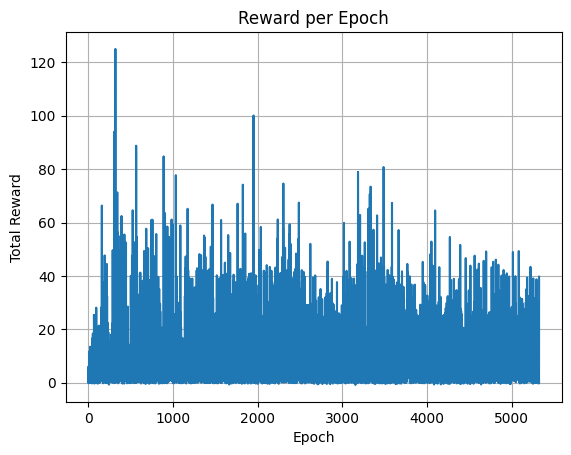

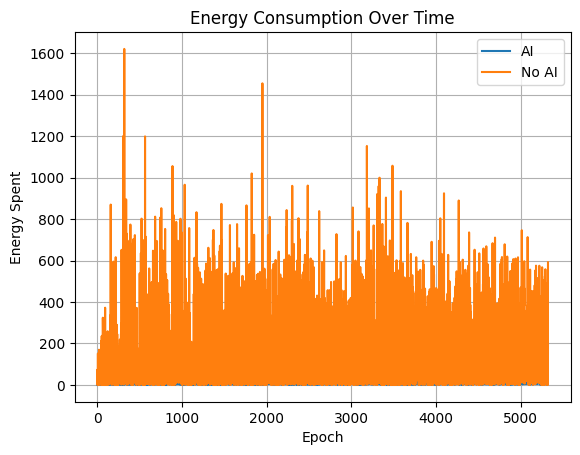

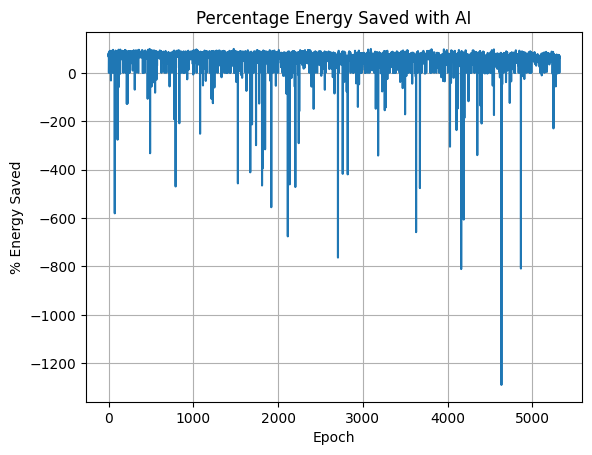

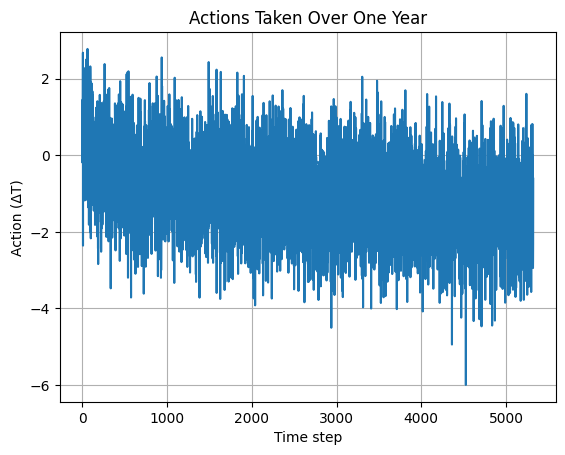

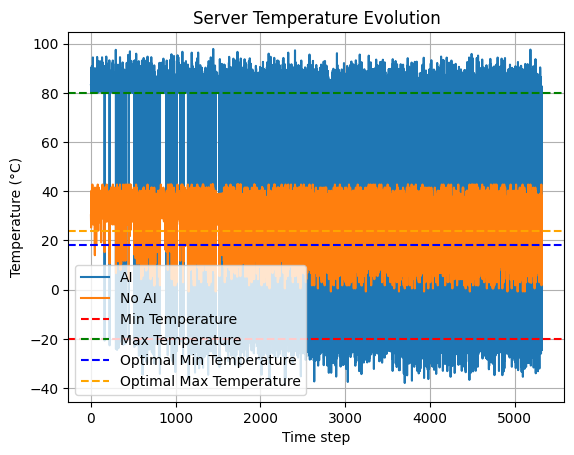

In [13]:
# ==== 2. PLOTTING RESULTS ====# 

# 1. Total Reward per Epoch
plt.figure()
plt.plot(reward_history)
plt.xlabel("Epoch")
plt.ylabel("Total Reward")
plt.title("Reward per Epoch")
plt.grid(True)
plt.show()

# 2. Energy Spent With and Without AI
plt.figure()
plt.plot(energy_ai_history, label="AI")
plt.plot(energy_noai_history, label="No AI")
plt.xlabel("Epoch")
plt.ylabel("Energy Spent")
plt.title("Energy Consumption Over Time")
plt.legend()
plt.grid(True)
plt.show()

# 3. Percentage Energy Saved
energy_ai_arr = np.array(energy_ai_history)
energy_noai_arr = np.array(energy_noai_history)
percent_saved = np.divide(
    (energy_noai_arr - energy_ai_arr) * 100,
    energy_noai_arr,
    out=np.zeros_like(energy_noai_arr, dtype=float),
    where=energy_noai_arr != 0
)
plt.figure()
plt.plot(percent_saved)
plt.xlabel("Epoch")
plt.ylabel("% Energy Saved")
plt.title("Percentage Energy Saved with AI")
plt.grid(True)
plt.show()

# 4. Actions Over Time
plt.figure()
plt.plot(actions_log)
plt.xlabel("Time step")
plt.ylabel("Action (ΔT)")
plt.title("Actions Taken Over One Year")
plt.grid(True)
plt.show()

# 5. Temperature Evolution
plt.figure()
plt.plot(temperature_ai_log, label="AI")
plt.plot(temperature_noai_log, label="No AI")
# Add horizontal lines for max and min temperatures
plt.axhline(y=env.min_temperature, color='r', linestyle='--', label='Min Temperature')
plt.axhline(y=env.max_temperature, color='g', linestyle='--', label='Max Temperature')
plt.axhline(y=env.optimal_temperature[0], color='b', linestyle='--', label='Optimal Min Temperature')
plt.axhline(y= env.optimal_temperature[1], color='orange', linestyle='--', label='Optimal Max Temperature') 
plt.xlabel("Time step")
plt.ylabel("Temperature (°C)")
plt.title("Server Temperature Evolution")
plt.legend()
plt.grid(True)
plt.show()

### Evaluación de la performance del modelo

In [14]:
print("Evaluating one year of energy management...")

# --- Environment Setup ---
env = Environment(
    optimal_temperature=(18.0, 24.0),
    initial_month=0,
    initial_number_users=20,
    initial_rate_data=30,
)


# --- Load PPO model ---
model = ActorCritic(state_dim, hidden_dim)
state_dict = torch.load("./Data/model_ppo_continuous.pth", map_location=device)
model.load_state_dict(state_dict)
model.eval()
model.to(device)

# --- Evaluation Mode ---
env.train = False
state, _, _ = env.observe()

# --- Simulate 1 year (12 months * 30 days * 24 hours * 60 minutes) ---
for timestep in tqdm(range(12 * 30 * 24 * 60)):
    month = int(timestep / (30 * 24 * 60))

    # Convert state to tensor
    state_tensor = torch.tensor(state, dtype=torch.float32).to(device)

    # Get action from policy (no gradient)
    with torch.no_grad():
        dist, _ = model(state_tensor)
        action = dist.mean.item()  # Use mean of distribution for deterministic policy

    # Apply action directly (continuous control)
    next_state, _, _ = env.update_env(action, month)
    state = next_state  # move to next state

# --- Results ---
print(f"Total Energy spent with an AI: {env.total_energy_ai:.0f}")
print(f"Total Energy spent with no AI: {env.total_energy_noai:.0f}")
print(f"ENERGY SAVED WITH AI: {(env.total_energy_noai - env.total_energy_ai) / env.total_energy_noai * 100:.0f}%")

Evaluating one year of energy management...


100%|██████████| 518400/518400 [09:14<00:00, 935.43it/s] 

Total Energy spent with an AI: 1532311
Total Energy spent with no AI: 2398633
ENERGY SAVED WITH AI: 36%


### Resultados

El porcentaje de energía ahorrada varía en función de los experimentos. El porcentaje se determina simulando un ciclo anual completo. Ambos modelos pretenden mantener el servidor dentro de un rango de temperatura óptimo de 18° a 24°C. La simulación se realiza para pasos de tiempo de un minuto a lo largo de un año completo.

### Ejercicio

* **Mostrar un gráfico donde podamos ver la evolución de la energía en el tiempo tanto para la energía gastada con y sin AI.**

### Preguntas

**Conceptuales y Teóricas:**
* ¿Qué es el Deep Q-Learning y cómo se diferencia del Q-Learning tradicional?
* Explica el concepto de "replay memory" en Deep Q-Learning. ¿Por qué es importante?
* ¿Qué papel juega la función de pérdida (loss function) en el entrenamiento de una red Q en Deep Q-Learning?
* Describe cómo la técnica de "experience replay" mejora el proceso de aprendizaje en el Deep Q-Learning.
* ¿Qué es el "discount factor" en el contexto de Deep Q-Learning y cómo afecta al aprendizaje del agente?

**Sobre el Código y la Implementación:**
* En el código proporcionado para el problema de gestión energética, ¿cómo se determina la acción que debe tomar el agente en cada paso de tiempo?
* Describe cómo se actualiza el entorno después de que el agente toma una acción. ¿Qué información se utiliza para calcular el nuevo estado y la recompensa?
* Explica cómo se calcula la recompensa en este problema específico. ¿Qué incentivos y penalizaciones se consideran para el agente?
* ¿Cómo se maneja la exploración frente a la explotación en este problema de Deep Q-Learning?

**Aplicaciones y Análisis Crítico:**
* ¿Cuáles son las ventajas y desventajas de usar Deep Q-Learning en la gestión de la energía de un centro de datos?
* Considerando el problema de gestión energética, ¿qué modificaciones sugerirías para mejorar el rendimiento del modelo de Deep Q-Learning?
* Discute cómo cambiarías la arquitectura de la red neuronal para este problema específico y por qué.
* Analiza el impacto potencial de variar el tamaño del "replay memory" y el "batch size" en el rendimiento del aprendizaje.
* ¿Cómo podrías modificar el problema para hacerlo más complejo o realista? ¿Qué cambios en el modelo o el algoritmo serían necesarios?

### Adaptado de: 

* https://github.com/LaurentVeyssier/Minimize-Energy-consumption-with-Deep-Learning-model/tree/main

![Lenguaje Matemático](./Images/Matematicas.png)

![Contacto](./Images/Contacto.png)